## Plot generation

### Criteo

In [ ]:
time_rumble = {
    "Criteo": {
        'logistic\npipe 1': [19 * 60 + 41.761, 19*60+38.442s, 19*60+44.905s, 19*60+32.272s], 
        'linearSVC\npipe 1': [16 * 60 + 56.768, 16*60+30.972s, 16*60+30.827s, 16*60+52.258s],
        'logistic\npipe 2': [18 * 60 + 28.111, 18*60+13.680s, 18*60+29.549s, 18*60+16.941s], 
        'linearSVC\npipe 2': [13 * 60 + 13.732, 13*60+42.403s, 13*60+39.855s, 13*60+11.983s]
    },
    "YFCC": {
        'logistic\npipe 1': [8 * 60 + 5.402, 8*60+7.884s, 8*60+0.391s], 
        'RandomForest\npipe 1': [10 * 60 + 24.311, 10*60+0.890s, 10*60+2.786s],
        'linearSVC\npipe 1': [7 * 60 + 58.396, 7*60+53.598s, 7*60+56.472s],
        'logistic\npipe 2': [9 * 60 + 24.026, 9*60+12.869s, 9*60+13.568s], 
        'RandomForest\npipe 2': [11 * 60 + 30.792, 11*60+35.346s, 11*60+31.076s],
        'linearSVC\npipe 2': [9 * 60 + 16.841, 9*60+16.146s, 9*60+17.538s]
    }
}
time_spark = {
    "Criteo": {
        'logistic\npipe 1': [17 * 60 + 22.196, 17*60+11.879s, 17*60+19.892s, 16*60+38.362s], 
        'linearSVC\npipe 1': [10 * 60 + 48.642, 10*60+44.728s, 10*60+44.327s, 10*60+6.630s],
        'logistic\npipe 2': [18 * 60 + 45.418, 18*60+32.902s, 18*60+37.297s, 16*60+36.668s], 
        'linearSVC\npipe 2': [12 * 60 + 19.175, 11*60+47.367s, 12*60+0.198s, 12*60+15.801s]
    },
    "YFCC": {
        'logistic\npipe 1': [5 * 60 + 11.791, 5*60+20.494s, 5*60+12.701s], 
        'RandomForest\npipe 1': [7 * 60 + 16.017, 7*60+9.188s, 7*60+12.080s],
        'linearSVC\npipe 1': [5 * 60 + 14.051, 5*60+10.918s, 5*60+21.015s],
        'logistic\npipe 2': [6 * 60 + 41.339, 6*60+36.137s, 6*60+36.206s], 
        'RandomForest\npipe 2': [8 * 60 + 33.980, 8*60+31.048s, 8*60+34.267s],
        'linearSVC\npipe 2': [6 * 60 + 30.974, 6*60+37.519s, 6*60+39.004s]
    }
}

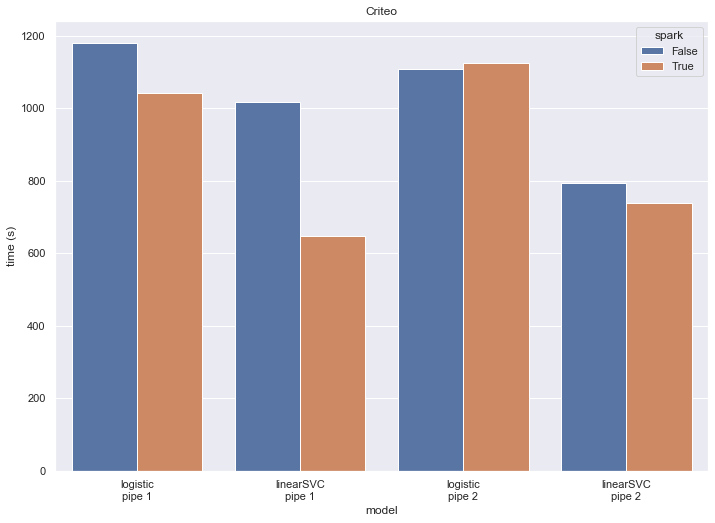

In [17]:
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


df = pd.DataFrame(columns = ['time','model','spark'])
df = df.append({'time (s)': 19 * 60 + 41.761, 'model': 'logistic\npipe 1', 'spark': False}, ignore_index=True)
df = df.append({'time (s)': 16 * 60 + 56.768, 'model': 'linearSVC\npipe 1', 'spark': False}, ignore_index=True)
df = df.append({'time (s)': 18 * 60 + 28.111, 'model': 'logistic\npipe 2', 'spark': False}, ignore_index=True)
df = df.append({'time (s)': 13 * 60 + 13.732, 'model': 'linearSVC\npipe 2', 'spark': False}, ignore_index=True)

df = df.append({'time (s)': 17 * 60 + 22.196, 'model': 'logistic\npipe 1', 'spark': True}, ignore_index=True)
df = df.append({'time (s)': 10 * 60 + 48.642, 'model': 'linearSVC\npipe 1', 'spark': True}, ignore_index=True)
df = df.append({'time (s)': 18 * 60 + 45.418, 'model': 'logistic\npipe 2', 'spark': True}, ignore_index=True)
df = df.append({'time (s)': 12 * 60 + 19.175, 'model': 'linearSVC\npipe 2', 'spark': True}, ignore_index=True)

ax = sns.barplot(x="model", y="time (s)", hue="spark", data=df).set_title("Criteo")



### YFCC

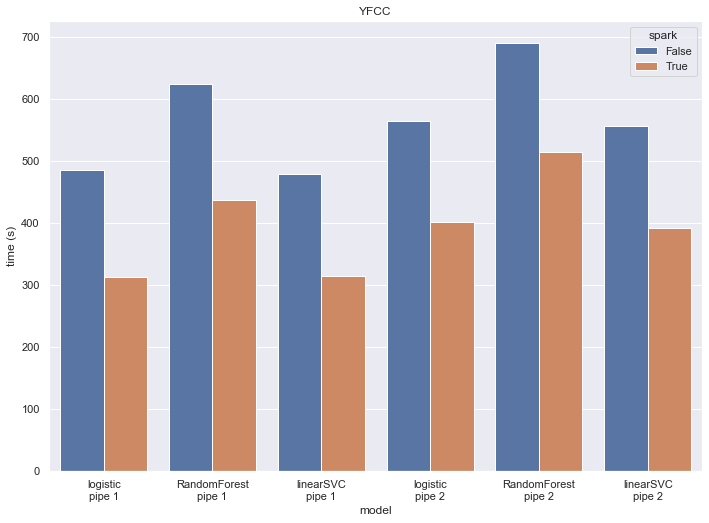

In [16]:
import pandas as pd
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

df = pd.DataFrame(columns = ['time','model','spark'])
df = df.append({'time (s)': 8 * 60 + 5.402, 'model': 'logistic\npipe 1', 'spark': False}, ignore_index=True)
df = df.append({'time (s)': 9 * 60 + 58.064, 'model': 'RandomForest\npipe 1', 'spark': False}, ignore_index=True)
df = df.append({'time (s)': 7 * 60 + 58.396, 'model': 'linearSVC\npipe 1', 'spark': False}, ignore_index=True)
df = df.append({'time (s)': 9 * 60 + 24.026, 'model': 'logistic\npipe 2', 'spark': False}, ignore_index=True)
df = df.append({'time (s)': 11 * 60 + 30.792, 'model': 'RandomForest\npipe 2', 'spark': False}, ignore_index=True)
df = df.append({'time (s)': 9 * 60 + 16.841, 'model': 'linearSVC\npipe 2', 'spark': False}, ignore_index=True)

df = df.append({'time (s)': 5 * 60 + 11.791, 'model': 'logistic\npipe 1', 'spark': True}, ignore_index=True)
df = df.append({'time (s)': 7 * 60 + 16.017, 'model': 'RandomForest\npipe 1', 'spark': True}, ignore_index=True)
df = df.append({'time (s)': 5 * 60 + 14.051, 'model': 'linearSVC\npipe 1', 'spark': True}, ignore_index=True)
df = df.append({'time (s)': 6 * 60 + 41.339, 'model': 'logistic\npipe 2', 'spark': True}, ignore_index=True)
df = df.append({'time (s)': 8 * 60 + 33.980, 'model': 'RandomForest\npipe 2', 'spark': True}, ignore_index=True)
df = df.append({'time (s)': 6 * 60 + 30.974, 'model': 'linearSVC\npipe 2', 'spark': True}, ignore_index=True)

ax = sns.barplot(x="model", y="time (s)", hue="spark", data=df).set_title("YFCC")